## Accelerating pure Python code with Numba and just-in-time compilation
`Numba` takes pure Python code and translates it automatically (just-in-time) into optimizaed machine code. In practice, this means we can write a non-vectorized function in Python, using `for` loops, and have this function vectorized automatically by a single decorator. 

Performance speedup compared to pure Python can reach several orders of magnitude and may even outmatch manually vectorized NumPy code.

In [2]:
import numpy as np
size = 200
iterations = 100

The following function generates the fractal in pure Python. It accepts an empty array `m` as argument.

In [3]:
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size * j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [4]:
m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)

([], <a list of 0 Text yticklabel objects>)

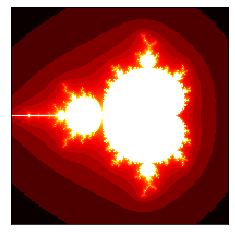

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(np.log(m), cmap=plt.cm.hot)
plt.xticks([]); plt.yticks([])

Now, we evaluate the time taken by this function:

In [6]:
%%timeit m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)

1.44 s ± 47.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's try to accelerate this function using Numba

In [7]:
import numba
from numba import jit, complex128

Next, we add the `@jit` decorator above the function definition. Numba tries to automatically infer the type of the local variables, but we can also specify the types explicitly:

In [9]:
@jit(locals=dict(c=complex128, z=complex128))
def mandelbrot_numba(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [10]:
%%timeit m = np.zeros((size, size))
mandelbrot_numba(m, size, iterations)

10.1 ms ± 815 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## How it works
Python bytecode is normally interpreted at runtime by the Python interpreter (e.g. CPython). By contrast, a Numba function is parsed and translated directly to machine code ahead of execution, using a powerful compiler architecture named **LLVM (Low Level Virtual Machine)**.

Citing the offical documentation:
>Numba is aware of NumPy arrays as typed memory regions and so can speedup code using NumPy arrays. Other, less well-typed code will be translated to Python C-API calls effectively removing the 'interpreter' but not removing the dynamic indirection.

### Comparison with manually vectorized code using NumPy
This is the standard way of accelerating pure Python code. In practice it means replacing the code inside the two loops over `i` and `j` with array computations.

This is relatively easy here as the operations closely follow the **Single Instruction, Multiple Data (SIMD)** paradigm

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
def initialize(size):
    x, y = np.meshgrid(np.linspace(-2, 1, size),
                      np.linspace(-1.5, 1.5, size))
    c = x + 1j*y
    z = c.copy()
    m = np.zeros((size, size))
    return c, z, m

In [13]:
size = 200
iterations = 100

def mandelbrot_numpy(c, z, m, iterations):
    for n in range(iterations):
        indices = np.abs(z) <= 10
        z[indices] = z[indices]**2 + c[indices]
        m[indices] = n

In [14]:
%%timeit -n1 -r10 c, z, m = initialize(size)
mandelbrot_numpy(c, z, m, iterations)

63.3 ms ± 22.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
